# Scaffold
|Element|Your Plan|
|-|-|
|Hypothesis|MN has a systematic difference in fatal crashes involving interstate junctions than other states.|
|Outcome/Metric/Test Stat|Mean fatal junction related interstate crashes in MN per year - non-MN|
|Unit of Analysis|1 state - year |
|Data Source(s)|https://cdan.dot.gov/query, https://catalog.data.gov/dataset/vehicle-miles-of-travel-by-functional-system-and-state-1980-2023-vm-2|
|Why this data works|It has yearly counts by state of fatal motor vehicle crashes related to interstate junctions |
|Uncertainty Metric|Number of motor vehicle crashes by state-year |
|Null Hypothesis|Null: MN has no difference in number of fatal interstate junction motor vehicle crashes. |

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

crash_filepath = "CrashReport_filled(in).csv"
miles_filepath = "Vehicle_Miles_of_Travel_by_State_1980_to_2023.csv"

In [2]:
# Read in data
#df = pd.read_csv("CrashReport_filled(in).csv")
crash = pd.read_csv(crash_filepath)
miles = pd.read_csv(miles_filepath)


In [ ]:
# Explore the Data
#print(df.sample(10))
#print(df.shape)
#print(df.info())
#print(df.describe())

In [3]:
# Create a dataframe of just state level
crash_clean = crash.query("Interstate == 'Interstate' and Junction == 'Junction'").reset_index(drop=True)
print(f"Rows before dropping total row {crash_clean.shape}")

# Identify year columns (4-digit column names)
year_cols = [col for col in crash_clean.columns 
             if str(col).isdigit() and len(str(col)) == 4]

# Everything else stays as identifiers
id_cols = [col for col in crash_clean.columns if col not in year_cols]

# Melt it
crash_clean = crash_clean.melt(
    id_vars=id_cols,
    value_vars=year_cols,
    var_name="Year",
    value_name="Value"
)

# ensure year is numeric and get rid of that total
crash_clean["Year"] = crash_clean["Year"].astype(int)
crash_clean["Value"] = pd.to_numeric(crash_clean["Value"], errors="coerce")
crash_clean = crash_clean.drop(columns = ["Total"])

crash_clean = crash_clean[crash_clean['State']!="Total"].copy()

# Clean and join with mileage driven on the interstate in each state
miles['Year'] = miles['Year'].astype(int)
miles_clean = miles[(miles['Year']>2012) & (miles['FClass']=="Interstate")].copy()
miles_clean = miles_clean.groupby(['Year','State','FClass'])['VMT'].sum().reset_index()

# Get the number of Junction Interstate Fatal Crashes per Interstate Total Miles Driven per Year
df_all = pd.merge(crash_clean, miles_clean, on=["State", "Year"], how="inner")
df_all['crash_per_mile'] = df_all['Value']/df_all['VMT']

crash_clean = df_all.copy()

print("Missing Values:")
print(crash_clean.isna().sum().sort_values(ascending=False))
print(f"Shape: \n{crash_clean.shape}")
print("Sampler:")
print(crash_clean.sample(5))



Rows before dropping total row (48, 15)
Missing Values:
State             0
Interstate        0
Junction          0
Year              0
Value             0
FClass            0
VMT               0
crash_per_mile    0
dtype: int64
Shape: 
(517, 8)
Sampler:
             State  Interstate  Junction  Year  Value      FClass  \
450  New Hampshire  Interstate  Junction  2022      0  Interstate   
270         Oregon  Interstate  Junction  2018      0  Interstate   
149        Florida  Interstate  Junction  2016      7  Interstate   
426       Arkansas  Interstate  Junction  2022      0  Interstate   
226      Tennessee  Interstate  Junction  2017      2  Interstate   

              VMT  crash_per_mile  
450  3.110383e+09    0.000000e+00  
270  9.842562e+09    0.000000e+00  
149  4.005519e+10    1.747589e-10  
426  1.072433e+10    0.000000e+00  
226  2.370263e+10    8.437884e-11  


## **Visualizations of Data**

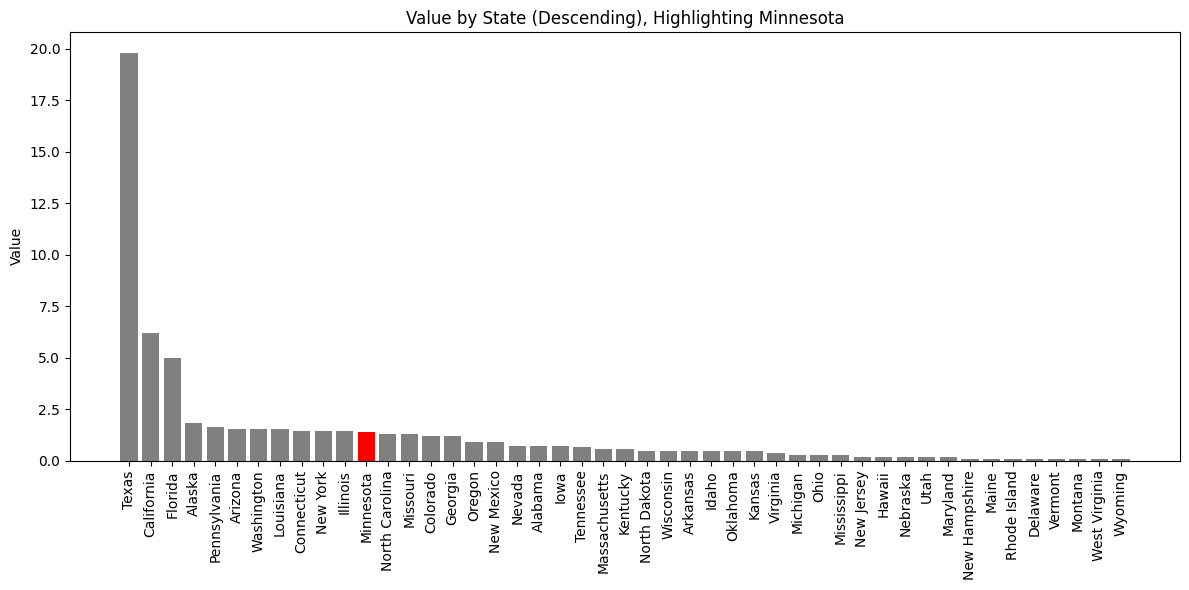

In [4]:
# Mean fatal interstate junction crashes per year 2013-2023
crashes_per_year = crash_clean.groupby("State")["Value"].mean().reset_index().sort_values('Value', ascending=False).reset_index(drop=True)

colors = ['red' if state == 'Minnesota' else 'gray' for state in crashes_per_year['State']]

plt.figure(figsize=(12,6))
plt.bar(crashes_per_year['State'], crashes_per_year['Value'], color=colors)
plt.xticks(rotation=90)
plt.ylabel("Value")
plt.title("Value by State (Descending), Highlighting Minnesota")
plt.tight_layout()
plt.show()

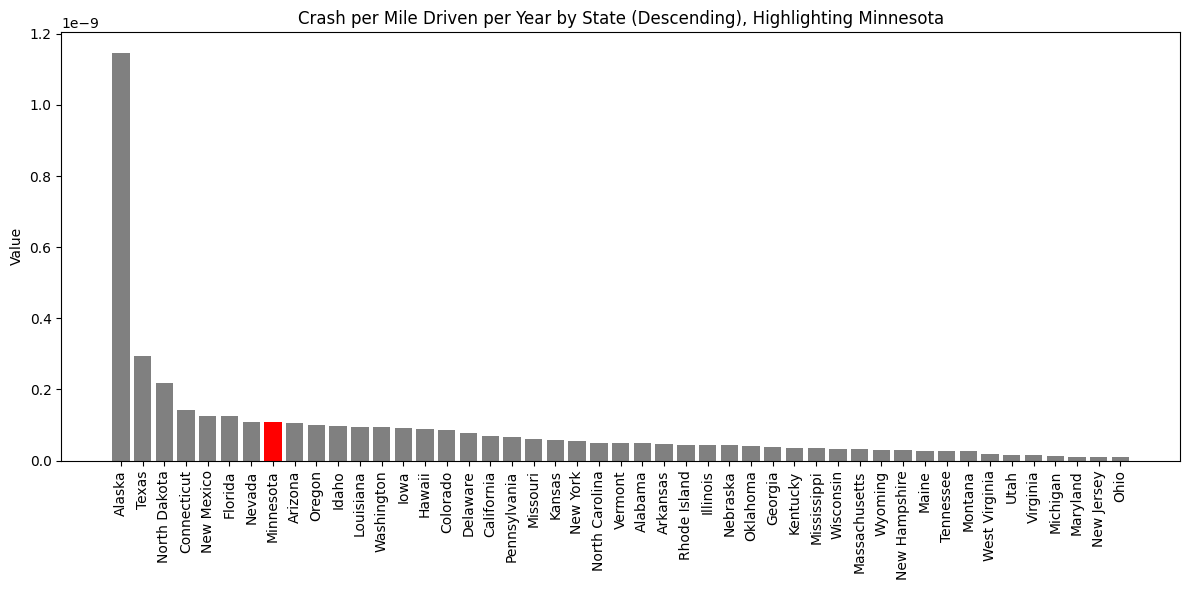

In [5]:
# Mean fatal interstate junction crashes per mile driven per year 2013-2023
crashes_per_mile_per_year = crash_clean.groupby("State")["crash_per_mile"].mean().reset_index().sort_values('crash_per_mile', ascending=False).reset_index(drop=True)

colors = ['red' if state == 'Minnesota' else 'gray' for state in crashes_per_mile_per_year['State']]

plt.figure(figsize=(12,6))
plt.bar(crashes_per_mile_per_year['State'], crashes_per_mile_per_year['crash_per_mile'], color=colors)
plt.xticks(rotation=90)
plt.ylabel("Value")
plt.title("Crash per Mile Driven per Year by State (Descending), Highlighting Minnesota")
plt.tight_layout()
plt.show()

## **Permutation Test on Raw # of Interstate Junction Crashes MN vs USA**

In [6]:
crash_clean['MN'] = np.where(crash_clean['State'] == 'Minnesota', 'MN', 'Not MN')
observed_diff = crash_clean.groupby('MN')['Value'].mean().loc['MN'] - crash_clean.groupby('MN')['Value'].mean().loc['Not MN']
observed_diff, crash_clean.groupby('MN')['Value'].mean().loc['MN'], crash_clean.groupby('MN')['Value'].mean().loc['Not MN']

(0.0671936758893279, 1.3636363636363635, 1.2964426877470356)

In [7]:
crash_copy = crash_clean.copy()
crash_copy = crash_copy.reset_index(drop=True)

results =[]
n = 10_000

for i in range(n):
    crash_copy['MN'] = crash_copy['MN'].sample(frac=1,replace=False).values
    means = crash_copy.groupby('MN')['Value'].mean()
    diff = means.loc["MN"] - means.loc["Not MN"]
    results.append(diff)

pval = 0

for i in range(0,n):
    if np.abs(results[i]) > observed_diff:
        pval += 1
    else:
        pval += 0

pval = pval/n

print(f"The p-value is {pval}")


The p-value is 0.9283


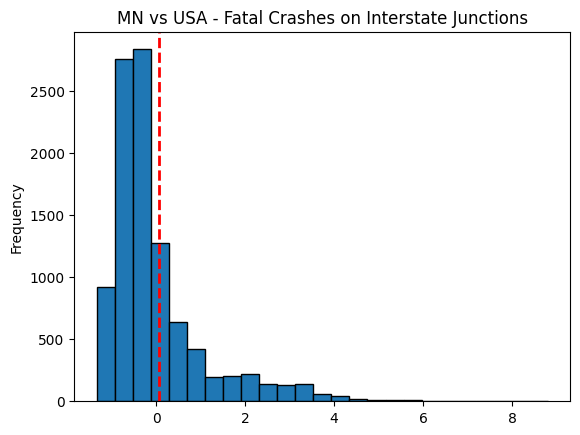

In [8]:
plt.figure()
plt.hist(results, bins = 25, edgecolor ='black')
plt.title("MN vs USA - Fatal Crashes on Interstate Junctions")
plt.ylabel("Frequency")
plt.axvline(x=observed_diff, color='red', linestyle='--', linewidth=2)
plt.show()

### Results for Raw # of Fatal Crashes: MN is not different than the rest of the country

## **Let's also look at total fatal crashes per mile driven, per year, by state**

In [9]:
fatal_total = crash.query("Interstate == 'Total' and Junction == 'Total' and State != 'Total'").reset_index(drop=True)

# Identify year columns (4-digit column names)
year_cols = [col for col in fatal_total.columns 
             if str(col).isdigit() and len(str(col)) == 4]

# Everything else stays as identifiers
id_cols = [col for col in fatal_total.columns if col not in year_cols]

# Melt it
fatal_total = fatal_total.melt(
    id_vars=id_cols,
    value_vars=year_cols,
    var_name="Year",
    value_name="Value"
)

# ensure year is numeric and get rid of that total
fatal_total["Year"] = fatal_total["Year"].astype(int)
fatal_total["Value"] = pd.to_numeric(fatal_total["Value"], errors="coerce")
fatal_total = fatal_total.drop(columns = ["Total"])


In [10]:
# Clean and join with mileage driven on the interstate in each state
miles['Year'] = miles['Year'].astype(int)
miles_sum = miles.groupby(["State","Year"])['VMT'].sum().reset_index()
miles_sum = miles_sum[miles_sum['Year']>2012].copy()

# Get the number of Junction Interstate Fatal Crashes per Interstate Total Miles Driven per Year
df_all = pd.merge(fatal_total, miles_sum, on=["State", "Year"], how="inner")
df_all['crash_per_mile'] = df_all['Value']/df_all['VMT']

total_fatal_crash_per_mile = df_all.copy()
total_fatal_crash_per_mile


,State,Interstate,Junction,Year,Value,VMT,crash_per_mile
0,Alabama,Total,Total,2013,767,6.504648e+10,1.179157e-08
1,Alaska,Total,Total,2013,49,4.848455e+09,1.010631e-08
2,Arizona,Total,Total,2013,782,6.058617e+10,1.290724e-08
3,Arkansas,Total,Total,2013,460,3.349327e+10,1.373410e-08
4,California,Total,Total,2013,2860,3.295341e+11,8.678919e-09
...,...,...,...,...,...,...,...
556,Virginia,Total,Total,2023,855,8.773019e+10,9.745790e-09
557,Washington,Total,Total,2023,733,5.980378e+10,1.225675e-08
558,West Virginia,Total,Total,2023,233,1.596239e+10,1.459681e-08
559,Wisconsin,Total,Total,2023,530,6.724840e+10,7.881229e-09


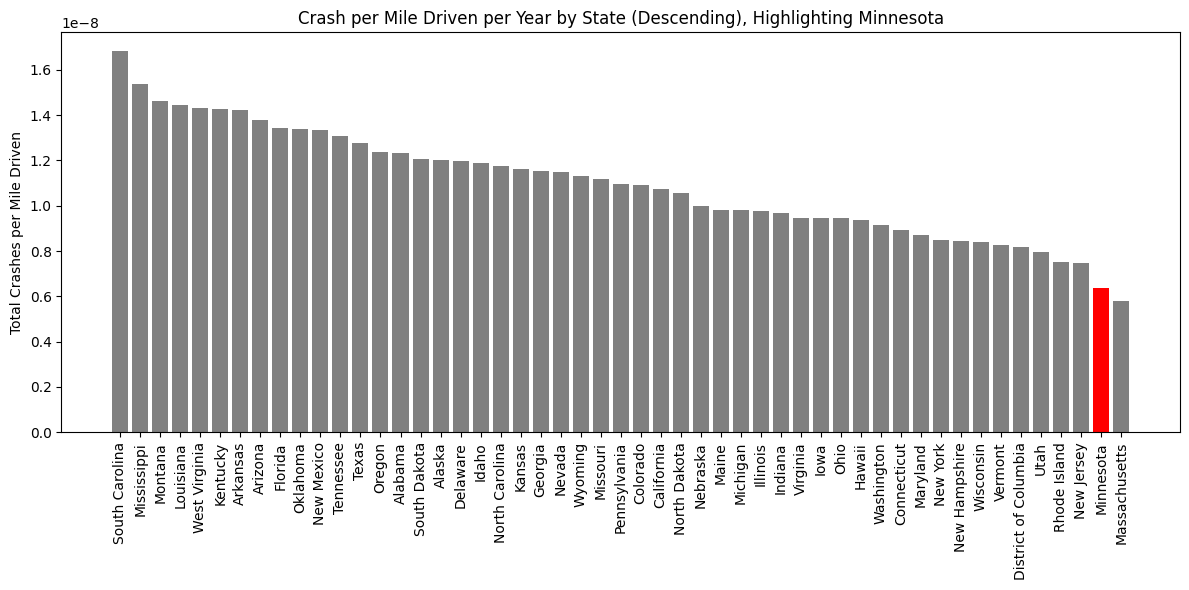

In [13]:
# Mean fatal interstate junction crashes per mile driven per year 2013-2023
crashes_per_mile_by_state = total_fatal_crash_per_mile.groupby("State")["crash_per_mile"].mean().reset_index().sort_values('crash_per_mile', ascending=False).reset_index(drop=True)

colors = ['red' if state == 'Minnesota' else 'gray' for state in crashes_per_mile_by_state['State']]

plt.figure(figsize=(12,6))
plt.bar(crashes_per_mile_by_state['State'], crashes_per_mile_by_state['crash_per_mile'], color=colors)
plt.xticks(rotation=90)
plt.ylabel("Total Crashes per Mile Driven")
plt.title("Crash per Mile Driven per Year by State (Descending), Highlighting Minnesota")
plt.tight_layout()
plt.show()

The p-value is 0.0367


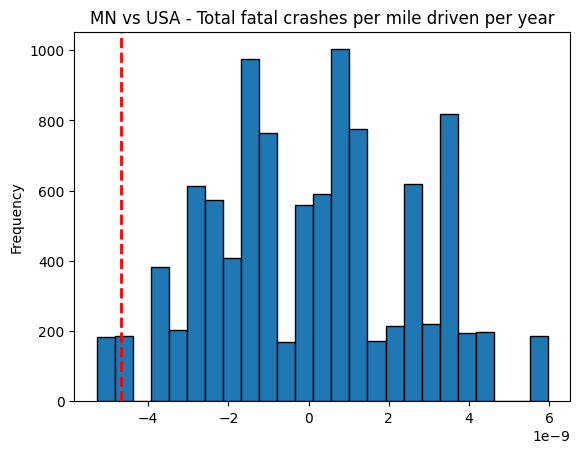

In [18]:
# Permutation Test - Does being in Minnesota have an effect on the number of crashes per mile driven?
# only at state level
crashes_per_mile_by_state['MN'] = np.where(crashes_per_mile_by_state['State'] == 'Minnesota', 'MN', 'Not MN')
observed_diff = crashes_per_mile_by_state.groupby('MN')['crash_per_mile'].mean().loc['MN'] - crashes_per_mile_by_state.groupby('MN')['crash_per_mile'].mean().loc['Not MN']
# observed_diff, crashes_per_mile_per_year.groupby('MN')['Value'].mean().loc['MN'], crashes_per_mile_per_year.groupby('MN')['Value'].mean().loc['Not MN']

fatal_crash_state_mile = crashes_per_mile_by_state.copy()
fatal_crash_state_mile = fatal_crash_state_mile.reset_index(drop=True)

results =[]
n = 10_000

for i in range(n):
    fatal_crash_state_mile['MN'] = fatal_crash_state_mile['MN'].sample(frac=1,replace=False).values
    means = fatal_crash_state_mile.groupby('MN')['crash_per_mile'].mean()
    diff = means.loc["MN"] - means.loc["Not MN"]
    results.append(diff)

pval = 0

for i in range(0,n):
    if np.abs(results[i]) > np.abs(observed_diff):
        pval += 1
    else:
        pval += 0

pval = pval/n

print(f"The p-value is {pval}")

plt.figure()
plt.hist(results, bins = 25, edgecolor ='black')
plt.title("MN vs USA - Total fatal crashes per mile driven per year")
plt.ylabel("Frequency")
plt.axvline(x=observed_diff, color='red', linestyle='--', linewidth=2)
plt.show()


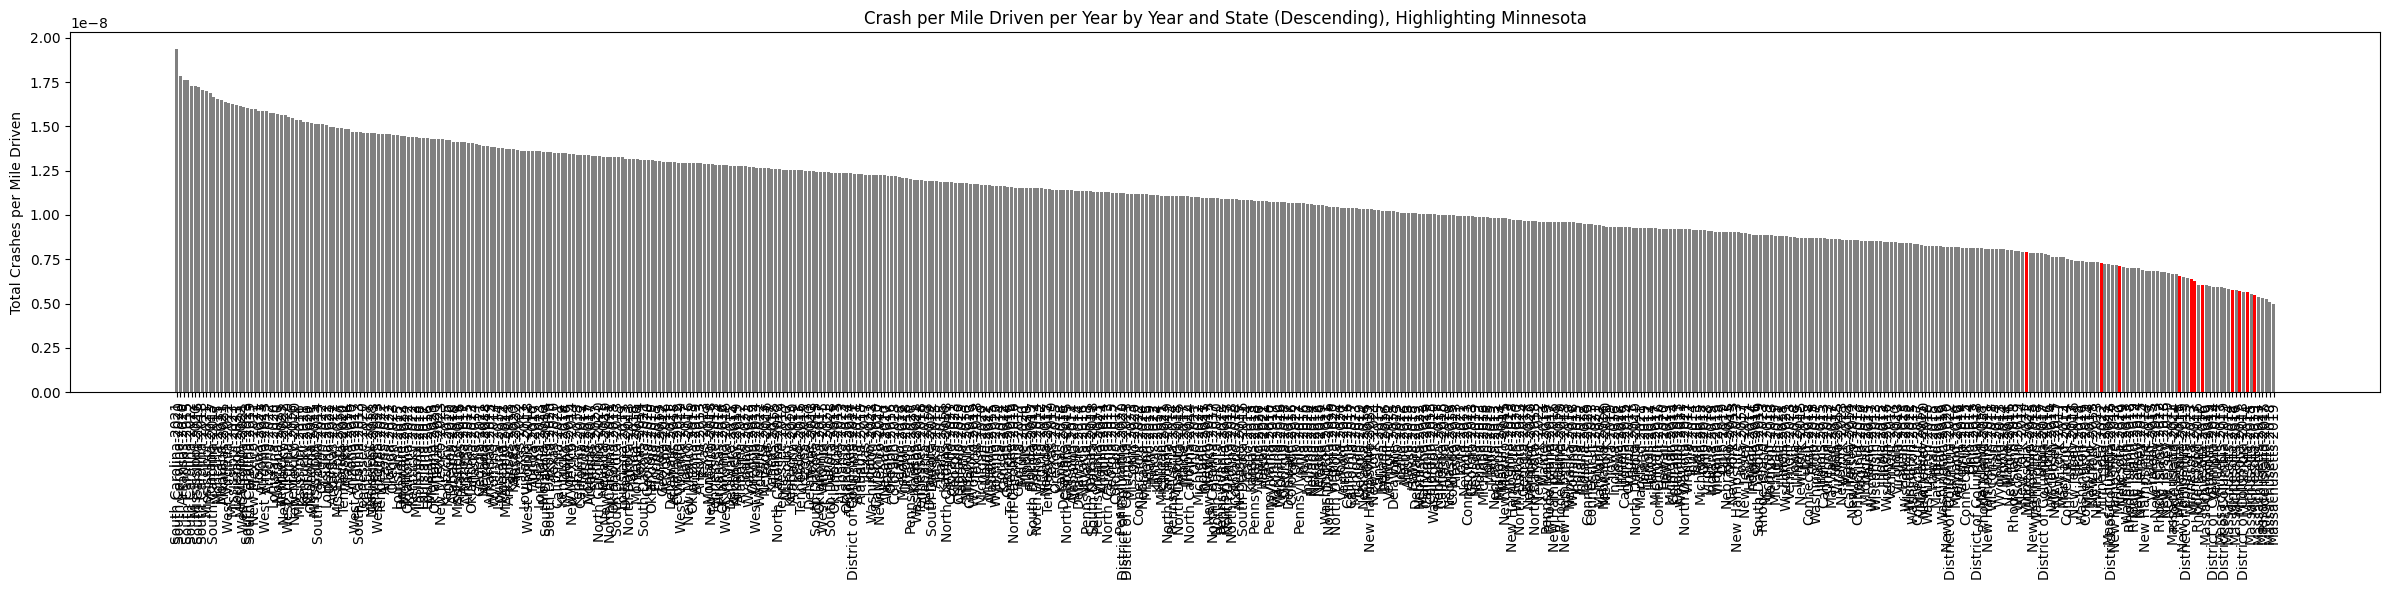

In [24]:
# Mean fatal interstate junction crashes per mile driven by year 2013-2023
crashes_per_mile_by_state_and_year = total_fatal_crash_per_mile[['State','Year','crash_per_mile']].sort_values('crash_per_mile', ascending=False).reset_index(drop=True).copy()
crashes_per_mile_by_state_and_year['State_Year'] = crashes_per_mile_by_state_and_year['State'] + "-" + crashes_per_mile_by_state_and_year['Year'].astype(str)
colors = ['red' if state == 'Minnesota' else 'gray' for state in crashes_per_mile_by_state_and_year['State']]

plt.figure(figsize=(24,6))
plt.bar(crashes_per_mile_by_state_and_year['State_Year'], crashes_per_mile_by_state_and_year['crash_per_mile'], color=colors)
plt.xticks(rotation=90)
plt.ylabel("Total Crashes per Mile Driven")
plt.title("Crash per Mile Driven per Year by Year and State (Descending), Highlighting Minnesota")
plt.tight_layout()
plt.show()

# **This chart looks terrible LETS DO CONFIDENCE INTERVALS**

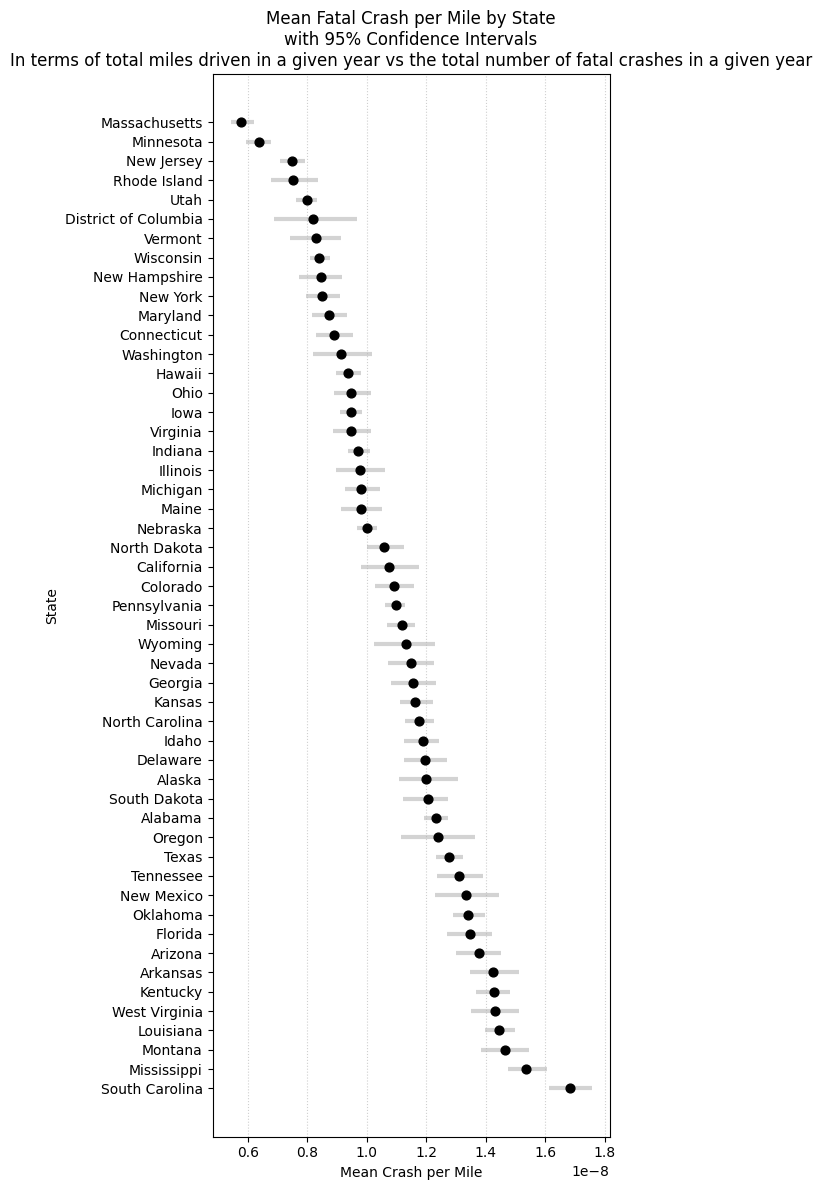

In [34]:
state_year_summary = crashes_per_mile_by_state_and_year.groupby('State')['crash_per_mile'].agg({'mean','count','std'}).reset_index()
state_year_summary['boot_se'] = pd.NA
state_year_summary['lower'] = pd.NA
state_year_summary['upper'] = pd.NA
n_sim = 1000

boot_means = {}

for idx, row in state_year_summary.iterrows():
    this_region = row['State']
    this_measures = crashes_per_mile_by_state_and_year.query(f"State =='{this_region}'")

    samples = []
    for _ in range(n_sim):
        this_sample = this_measures.sample(n=len(this_measures),replace = True)
        samples.append(np.mean(this_sample['crash_per_mile']))

    boot_means[this_region] = samples
    
    state_year_summary.loc[state_year_summary['State']==this_region,'boot_se'] = np.std(samples)
    state_year_summary.loc[state_year_summary['State']==this_region,'lower'] = np.quantile(samples,0.025)
    state_year_summary.loc[state_year_summary['State']==this_region,'upper'] = np.quantile(samples,0.975)
plt.figure(figsize=(6,12))

state_year_summary = state_year_summary.sort_values('mean', ascending=False).reset_index(drop=True)

# CI lines
plt.hlines(
    y=state_year_summary['State'],
    xmin=state_year_summary['lower'],
    xmax=state_year_summary['upper'],
    color='lightgray',
    lw=3,
    zorder=1
)

# Point estimates
plt.scatter(
    state_year_summary['mean'],
    state_year_summary['State'],
    s=40,
    color='black',
    zorder=2
)
plt.xlabel('Mean Crash per Mile')
plt.ylabel('State')
plt.title('Mean Fatal Crash per Mile by State\nwith 95% Confidence Intervals\nIn terms of total miles driven in a given year vs the total number of fatal crashes in a given year')
#plt.xlim(4, 5)
plt.grid(axis='x', linestyle=':', alpha=0.6, zorder=0)
plt.tight_layout()
plt.show()

In [35]:
# Permutation Test - Does being in Minnesota have an effect on the number of crashes per mile driven?
# state and year level

crashes_per_mile_by_state_and_year['MN'] = np.where(crashes_per_mile_by_state_and_year['State'] == 'Minnesota', 'MN', 'Not MN')
observed_diff = crashes_per_mile_by_state_and_year.groupby('MN')['crash_per_mile'].mean().loc['MN'] - crashes_per_mile_by_state_and_year.groupby('MN')['crash_per_mile'].mean().loc['Not MN']
# observed_diff, total_fatal_crash_per_mile.groupby('MN')['crash_per_mile'].mean().loc['MN'], total_fatal_crash_per_mile.groupby('MN')['crash_per_mile'].mean().loc['Not MN']

The p-value is 0.0


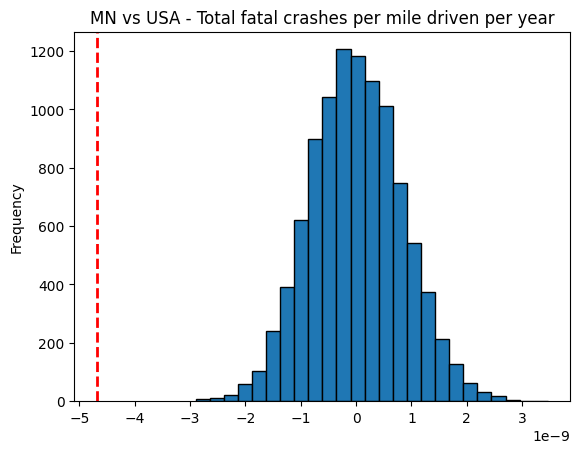

In [36]:
fatal_crash_state_year_mile = crashes_per_mile_by_state_and_year.copy()
fatal_crash_state_year_mile = fatal_crash_state_year_mile.reset_index(drop=True)

results =[]
n = 10_000

for i in range(n):
    fatal_crash_state_year_mile['MN'] = fatal_crash_state_year_mile['MN'].sample(frac=1,replace=False).values
    means = fatal_crash_state_year_mile.groupby('MN')['crash_per_mile'].mean()
    diff = means.loc["MN"] - means.loc["Not MN"]
    results.append(diff)

pval = 0

for i in range(0,n):
    if np.abs(results[i]) > np.abs(observed_diff):
        pval += 1
    else:
        pval += 0

pval = pval/n

print(f"The p-value is {pval}")

plt.figure()
plt.hist(results, bins = 25, edgecolor ='black')
plt.title("MN vs USA - Total fatal crashes per mile driven per year")
plt.ylabel("Frequency")
plt.axvline(x=observed_diff, color='red', linestyle='--', linewidth=2)
plt.show()